In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip
import random
import scipy

# Setup

In [2]:
# Define Pauli matrices
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
I = np.eye(2, dtype=complex)

def pauli_on(n_qubits, pauli, position):
    ops = [I] * n_qubits
    ops[position] = pauli
    return np.kron(np.kron(ops[0], ops[1]), ops[2]) if n_qubits == 3 else np.kron.reduce(ops)

In [3]:
# ---- Rectangular finite-width pulses and their reverses ----
def U(H, tp):
    return scipy.linalg.expm(-1j*(np.pi/2*H+tp*H_S))
def U_rev(H, tp):
    return scipy.linalg.expm(-1j*(-np.pi/2*H+tp*H_S))

# Gate infidelity
def gate_fidelity(U,V,site):
    return 1-abs(np.trace(U@V.conj().T))/2**site

# Free evolution
def f(tau):
    return scipy.linalg.expm(-1j*H_S*tau)

In [4]:
n = 3
X1, X2, X3 = (pauli_on(n, X, i) for i in range(3))

# Pairwise combinations
X12 = X1 + X2
X13 = X1 + X3
X23 = X2 + X3

In [5]:
# ---- Define the 3-qubit system ----
H_S = np.kron(np.kron(I, Z),Z) + np.kron(np.kron(Z, I),Z) +  np.kron(np.kron(Z, Z),I)

# Test DCG constructions for $X_iX_j$


We verify the first-order ($q = 1$) DCG implementation of various $X$-type operations used in the paper:

\begin{align}\label{DCG_algo1_Ising}
     P_{\rm DCG} = \widetilde{P}(2t_p)  \widetilde{X}_1 \widetilde{X}_2 \widetilde{X}_1 \widetilde{X}_2 \widetilde{X}_2 \widetilde{I}_P \widetilde{X}_1 \widetilde{I}_P \widetilde{X}_2 \widetilde{I}_P \widetilde{X}_1
\end{align}

where $\widetilde{I}_P := \widetilde{P}^{\text{rev}}\widetilde{P}$ implements an effective identity operation. Here, $\widetilde{P}$ and its time-reversed counterpart $\widetilde{P}^{\text{rev}}$.


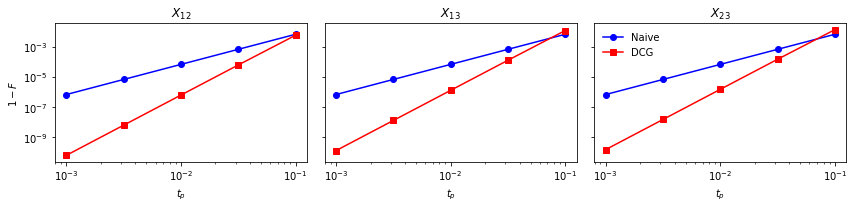

In [6]:
# ---- Parameters ----
tplist = np.logspace(-3, -1, 5)

# ---- Define generic routines ----
def naive_sequence(H, tp):
    """Naive evolution under H."""
    return U(H, tp)

def dcg_sequence(H, tp):
    """Finite-width DCG construction with refocusing."""
    H_block = U(H, tp)
    X1_block = U(X1, tp)
    X2_block = U(X2, tp)
    I_Q = U_rev(H, tp) @ H_block
    return (
        U(H, 2 * tp)
        @ X1_block
        @ X2_block
        @ X1_block
        @ X2_block
        @ X2_block
        @ I_Q
        @ X1_block
        @ I_Q
        @ X2_block
        @ I_Q
        @ X1_block
    )

def run_experiment(H, label):
    """Compute gate infidelities for naive vs DCG for given Hamiltonian."""
    e_naive, e_DCG = [], []
    U_targ = U(H, 0)
    for tp in tplist:
        U_naive = naive_sequence(H, tp)
        U_dcg = dcg_sequence(H, tp)
        e_naive.append(gate_fidelity(U_naive, U_targ, 3))
        e_DCG.append(gate_fidelity(U_dcg, U_targ, 3))
    return np.array(e_naive), np.array(e_DCG), label

# ---- Run for X12, X13, X23 ----
results = [
    run_experiment(X12, r"$X_{12}$"),
    run_experiment(X13, r"$X_{13}$"),
    run_experiment(X23, r"$X_{23}$"),
]

# ---- Plot all ----
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

for ax, (e_naive, e_DCG, label) in zip(axes, results):
    ax.plot(tplist, e_naive, 'o-', color='blue', label='Naive')
    ax.plot(tplist, e_DCG, 's-', color='red', label='DCG')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(label)
    #ax.grid(True, which='both', ls=':', lw=0.5)

axes[0].set_ylabel(r"$1-F$")
for ax in axes:
    ax.set_xlabel(r"$t_p$")
axes[-1].legend(frameon=False)

plt.tight_layout()
plt.show()

Any other $X$-type DCG operations can be implemented analogoulsy

# Robust quantum simulation using DCGs


Here, we sample $J_{ij}$ for the target Hamiltonian coupling strengths, which determine interpulse delays:

\begin{align}
    \{\tau_k\} = \frac{-T}{2J} \times \{0, J_{23} + J_{13}, J_{12}+J_{23}, J_{12} - J_{13}\}.
\end{align}

In [7]:
def dcg_gate(H, tp, X1, X2):
    """Finite-width DCG construction for Hamiltonian H."""
    H_block = U(H, tp)
    I_Q = U_rev(H, tp) @ H_block
    return (
        U(H, 2 * tp)
        @ U(X1, tp)
        @ U(X2, tp)
        @ U(X1, tp)
        @ U(X2, tp)
        @ U(X2, tp)
        @ I_Q
        @ U(X1, tp)
        @ I_Q
        @ U(X2, tp)
        @ I_Q
        @ U(X1, tp)
    )

#  --------- Parameters and couplings ---------
random.seed(0)  

J_12, J_13, J_23 = [random.uniform(-1, 1) for _ in range(3)]
#J_12, J_13, J_23 = -0.743, 0.414, 0.433 #parameter used in the paper
taus = -0.5 * np.array([J_23 + J_13, J_12 + J_23, J_12 + J_13])
T = 1

print(f"Sampled couplings:\n  J12 = {J_12:.3f},  J13 = {J_13:.3f},  J23 = {J_23:.3f}")
print(f"Derived taus:\n  tau1 = {taus[0]:.3f},  tau2 = {taus[1]:.3f},  tau3 = {taus[2]:.3f}")

# Construct target Hamiltonian
H_T = (
    J_12 * np.kron(np.kron(Z, Z), I)
    + J_13 * np.kron(np.kron(Z, I), Z)
    + J_23 * np.kron(np.kron(I, Z), Z)
)

Sampled couplings:
  J12 = 0.689,  J13 = 0.516,  J23 = -0.159
Derived taus:
  tau1 = -0.179,  tau2 = -0.265,  tau3 = -0.602


We now perform the simulation using the designed pulse sequence.  
The sequence of pulses is defined as

\begin{align}
    \{P_k\} = \{X_1X_2,\, X_2X_3,\, X_1X_2,\, X_2X_3\},
\end{align}

which is applied to implement the desired evolution.  
Any segment involving negative evolution time is realized exactly through the corresponding pulse sequence as follows:

\begin{align}
e^{iH_0\tau} = X_2 e^{-iH_0\tau} X_1 e^{-iH_0\tau} X_2 e^{-iH_0\tau} X_1.
\end{align}

We compare two simulation strategies:  
(i) the *raw* simulation, where each operation $P_k$ is implemented directly using a naive finite-width pulse, and  
(ii) the *DCG-enhanced* simulation, where each $P_k$ is replaced by its dynamically corrected gate (DCG) counterpart (tested above)

In [8]:
# --------- Simulation loop ---------

tplist = np.logspace(-4, -1, 20)
e_naive, e_DCG = [], []

U_targ = scipy.linalg.expm(-1j * H_T * T)

for tp in tplist:
    # --- Primitive gates ---
    X12gate, X13gate, X23gate = [U(H, tp) for H in (X12, X13, X23)]
    X1gate, X2gate = U(X1, tp), U(X2, tp)

    # --- Helper for naive negative-time correction (depends on tau_k) ---
    def neg_block_naive(tau_val):
        """Implements f(-|tau_val|) using X1, X2 refocusing sequence."""
        return (
            X2gate
            @ f(-tau_val)
            @ X1gate
            @ f(-tau_val)
            @ X2gate
            @ f(-tau_val)
            @ X1gate
        )

    def eff_f(tau_val):
        """Use f(tau_val) if tau>=0 else composite reverse block."""
        return f(tau_val) if tau_val >= 0 else neg_block_naive(tau_val)

    # --- Naive total sequence ---
    U_naive = (
        X23gate
        @ eff_f(taus[2])
        @ X12gate
        @ eff_f(taus[1])
        @ X23gate
        @ eff_f(taus[0])
        @ X12gate
    )

    # --- DCG versions ---
    DCG12 = dcg_gate(X12, tp, X1, X2)
    DCG13 = dcg_gate(X13, tp, X1, X2)
    DCG23 = dcg_gate(X23, tp, X1, X2)
    DCG1  = dcg_gate(X1,  tp, X1, X2)
    DCG2  = dcg_gate(X2,  tp, X1, X2)

    def neg_block_DCG(tau_val):
        """Robust version of f(-|tau_val|) using DCG1, DCG2."""
        return (
            DCG2
            @ f(-tau_val)
            @ DCG1
            @ f(-tau_val)
            @ DCG2
            @ f(-tau_val)
            @ DCG1
        )

    def eff_f_DCG(tau_val):
        """Use f(tau_val) if tau>=0 else robust composite block."""
        return f(tau_val) if tau_val >= 0 else neg_block_DCG(tau_val)

    # --- DCG total sequence ---
    U_DCG = (
        DCG23
        @ eff_f_DCG(taus[2])
        @ DCG12
        @ eff_f_DCG(taus[1])
        @ DCG23
        @ eff_f_DCG(taus[0])
        @ DCG12
    )

    # --- Fidelity evaluation ---
    e_naive.append(gate_fidelity(U_naive, U_targ, 3))
    e_DCG.append(gate_fidelity(U_DCG, U_targ, 3))


e_naive, e_DCG = np.array(e_naive), np.array(e_DCG)

Scaling slopes: naive = 2.0,  DCG = 4.0


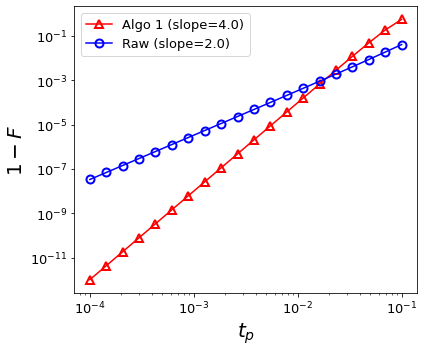

In [9]:

#  --------- Log–log slope (scaling exponent) ---------

def slope_loglog(x, y):
    logx, logy = np.log10(x), np.log10(y)
    coeffs = np.polyfit(logx, logy, 1)
    return coeffs[0]  # slope

slope_naive = slope_loglog(tplist, e_naive)
slope_dcg = slope_loglog(tplist, e_DCG)
print(f"Scaling slopes: naive = {slope_naive:.1f},  DCG = {slope_dcg:.1f}")

# ---------  Plot results ---------

ms = 8
fig, ax = plt.subplots(figsize=(6,5))


ax.plot(tplist, e_DCG, "^-", color="red",
        markersize=ms, markerfacecolor="none", markeredgewidth=2, label=f"Algo 1 (slope={slope_dcg:.1f})")
ax.plot(tplist, e_naive, "o-", color="blue",
        markersize=ms, markerfacecolor="none", markeredgewidth=2, label=f"Raw (slope={slope_naive:.1f})")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$t_p$", fontsize=20)
ax.set_ylabel(r"$1 - F$", fontsize=20)
ax.legend(fontsize=13)
ax.tick_params(axis="both", which="major", labelsize=13)

plt.tight_layout()
#plt.savefig("Ising_Numerics", dpi = 200)
plt.show()